In [1]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore
from torchmetrics.functional.multimodal import clip_score
import numpy as np
from PIL import Image
from datasets import load_dataset
from functools import partial
import pickle
import random

/home/ajoshi72/.conda/envs/FullPipeline1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
dataset = load_dataset('poloclub/diffusiondb', '2m_first_1k')
my_1k_data = dataset['train']

In [5]:
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    # images_int = (images * 255).astype("uint8")
    # permute = [2, 0, 1]
    imageRGB = torch.from_numpy(images)
    clip_score = clip_score_fn(imageRGB.permute(2,0,1), prompts).detach()
    # clip_score = clip_score_fn(imageRGB, prompts).detach()
    return round(float(clip_score), 4)



In [24]:
images = dataset['train']['image']
prompts = dataset['train']['prompt']
# print(dataset['train'])

In [7]:
def savelist(clipsc,t):
    with open("nlp/clipscores/score_"+str(t), "wb") as fp:   #Pickling
        pickle.dump(clipsc, fp)

In [14]:
# with open("nlp/clipscores/score_500", "rb") as fp:   # Unpickling
#    b = pickle.load(fp)

In [16]:
# clip_scores = []
clip_scores = b
print(len(clip_scores))
for i in range(1001):
    if i%100==0:
        print(i)
        savelist(clip_scores,i)
    clip_scores.append(calculate_clip_score(np.array(images[i]), prompts[i]))


500


Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
/home/dmsheth1/.conda/envs/medclip_env1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered caption longer than max_position_embeddings=77. Will truncate captions to this length.If longer captions are needed, initialize argument `model_name_or_path` with a model that supportslonger sequences
  warnings.warn(*args, **kwargs)  # noqa: B028
Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

600


Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors


700
800
900


Token indices sequence length is longer than the specified maximum sequence length for this model (81 > 77). Running this sequence through the model will result in indexing errors


In [29]:
# clip_scores.append(calculate_clip_score(np.array(images[999]), prompts[999]))

In [5]:
with open("nlp/clipscores/score_1000", "rb") as fp:   # Unpickling
   clip_scores = pickle.load(fp)

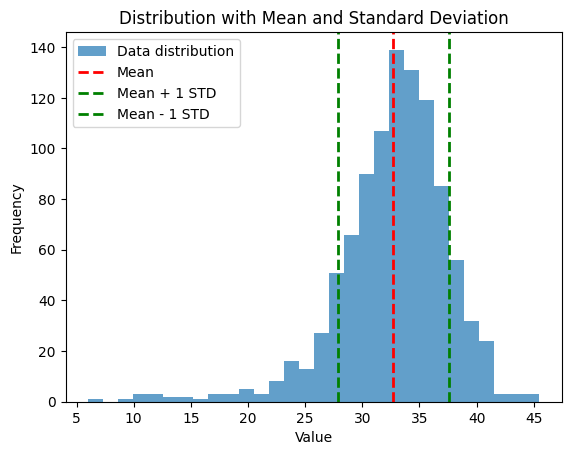

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# data = np.random.normal(loc=0, scale=1, size=1000)  # 1000 random numbers from a normal distribution
# data = nums
data = clip_scores

mean = np.mean(data)
std_dev = np.std(data)

plt.hist(data, bins=30, alpha=0.7, label='Data distribution')

plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean + std_dev, color='g', linestyle='dashed', linewidth=2, label='Mean + 1 STD')
plt.axvline(mean - std_dev, color='g', linestyle='dashed', linewidth=2, label='Mean - 1 STD')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution with Mean and Standard Deviation')
plt.legend()

plt.show()

## Integrating QnA pipeline

In [4]:
with open("/home/ajoshi72/score_1000", "rb") as fp:   # Unpickling
   b = pickle.load(fp)

In [5]:
mean = np.mean(b)
std_dev = np.std(b)
upperbound = mean + std_dev
lowerbound = mean - std_dev
print(lowerbound,upperbound)

27.83245704705378 37.57099535294621


In [6]:
from transformers import AutoTokenizer
import transformers
import torch
import json
import re

model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:29<00:00, 14.95s/it]


In [7]:
samp = """I will give you a prompt. Generate 6 to 7 pairs of questions and answers from this prompt. You can include question about what attributes mentioned in the prompt such as shape, size, color etc. Think of these questions in such a way that their answers complete the description of the prompt and can be used to make an image through the features described in it. As an example, look at this prompt and the question answer pair generated for it:
Prompt: a little girl embroidery, fine art, muted background, calm colore. oil paiting by jan vermeer, masterpiese Question-Answer pair to be generated: Q. What is the object? A. The object is an embroidery of a little girl Q. What is the background color? A. The background is muted  Q.What type of painting is it? A. It is an oil painting. Q.Who is the painter? A. Jan Vermeer is the painter Generate similar question answer pairs for the following prompt:"""

# Initialize the final output dictionary
final_output = {}

# for index in range(len(my_1k_data['image'])):
for index,s in enumerate(b):
    if s<= upperbound and s>=lowerbound:
        sequences = pipeline(
            samp + my_1k_data['prompt'][index] + "Question-Answer pair to be generated:",
            do_sample=False,
            top_k=50,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            temperature=1e-05,
            top_p=1,
            repetition_penalty=1.0,
            length_penalty=1
        )
    
        text = sequences[0]['generated_text']
    
        input_text = text.split('Question-Answer pair to be generated:')
        
        qa_dict = {}
        # qa_list = []
        for i in range(2, len(input_text), 2):
            questions = re.findall(r'Q\..*?\?', input_text[i])
            answers = re.findall(r'A\..*?(?=(?:Q\.|$))', input_text[i])
    
            for question, answer in zip(questions, answers):
                # newdict = {} #new dict for each qa
                # newdict[question.strip()] = answer.strip()
                # qa_list.append(newdict)
                qa_dict[question.strip()[3:]] = answer.strip()[3:]
                
    
        final_output[index] = {
            'image': my_1k_data['image'][index],
            'prompt': my_1k_data['prompt'][index],
            # 'qa_pairs': qa_list
            'qa_pairs': qa_dict
            
        }
        break
print(final_output)



/home/ajoshi72/.conda/envs/FullPipeline1/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-05` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


{1: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x640 at 0x15545F36F940>, 'prompt': 'portrait of a dancing eagle woman, beautiful blonde haired lakota sioux goddess, intricate, highly detailed art by james jean, ray tracing, digital painting, artstation, concept art, smooth, sharp focus, illustration, artgerm and greg rutkowski and alphonse mucha, vladimir kush, giger, 8 k ', 'qa_pairs': {'What is the subject of the artwork?': 'The subject is a portrait of a dancing eagle woman.', 'Who is the artist?': 'James Jean is the artist.', 'What is the medium used in the artwork?': 'Digital painting is used in the artwork.', 'What is the level of detail in the artwork?': 'The level of detail is highly detailed.', 'What is the focus of the artwork?': 'The focus is smooth and sharp.', 'What is the style of the artwork?': 'The style is illustration.', 'Who are some of the artists that have inspired the artist?': 'Artists such as Alphonse Mucha, Vladimir Kush, and H.R. Giger ha

In [10]:
qa_list

[{'Q. What is the subject of the artwork?': 'A. The subject is a portrait of a dancing eagle woman.'},
 {'Q. Who is the artist?': 'A. James Jean is the artist.'},
 {'Q. What is the medium used in the artwork?': 'A. Digital painting is used in the artwork.'},
 {'Q. What is the level of detail in the artwork?': 'A. The level of detail is highly detailed.'},
 {'Q. What is the focus of the artwork?': 'A. The focus is smooth and sharp.'},
 {'Q. What is the style of the artwork?': 'A. The style is illustration.'},
 {'Q. Who are some of the artists that have inspired the artist?': 'A. Artists such as Alphonse Mucha, Vladimir Kush, and H.R. Giger have inspired the artist.'}]

In [21]:
final_output

{1: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x640>,
  'prompt': 'portrait of a dancing eagle woman, beautiful blonde haired lakota sioux goddess, intricate, highly detailed art by james jean, ray tracing, digital painting, artstation, concept art, smooth, sharp focus, illustration, artgerm and greg rutkowski and alphonse mucha, vladimir kush, giger, 8 k ',
  'qa_pairs': [{'Q. What is the subject of the artwork?': 'A. The subject is a portrait of a dancing eagle woman.'},
   {'Q. Who is the artist?': 'A. James Jean is the artist.'},
   {'Q. What is the medium used in the artwork?': 'A. Digital painting is used in the artwork.'},
   {'Q. What is the level of detail in the artwork?': 'A. The level of detail is highly detailed.'},
   {'Q. What is the focus of the artwork?': 'A. The focus is smooth and sharp.'},
   {'Q. What is the style of the artwork?': 'A. The style is illustration.'},
   {'Q. Who are some of the artists that have inspired the artist?': 'A. Artis

# MLLM Pipeline:

In [ ]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch
from PIL import Image
import requests

torch.manual_seed(0)
np.random.seed(0)

# device = "cuda" if torch.cuda.is_available() else "cpu"
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b")
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

for key, value in final_output.items():
    image = value['image']
    # display(image)
    questions = value['qa_pairs'].keys()
    # print(questions)

    # Loop over each question for the current image
    for question in questions:
        string = question
        print(string)
        # prompt = "answer this question about the image: "
        inputs = processor(images=image, text=string, return_tensors="pt")

        outputs = model.generate(
            **inputs,
            do_sample=False,
            num_beams=5,
            max_length=256,
            min_length=1,
            top_p=0.9,
            repetition_penalty=1.5,
            length_penalty=1.0,
            temperature=1,
        )

        generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
        print(generated_text)

        
        if 'answers_blip' not in value:
            value['answers_blip'] = {}
        value['answers_blip'][question] = generated_text

# Print the updated final_output
print(final_output)

qformer_tokenizer/tokenizer_config.json: 100%|██████████| 343/343 [00:00<00:00, 116kB/s]
qformer_tokenizer/vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 4.01MB/s]
qformer_tokenizer/tokenizer.json: 100%|██████████| 712k/712k [00:00<00:00, 30.7MB/s]
qformer_tokenizer/added_tokens.json: 100%|██████████| 21.0/21.0 [00:00<00:00, 51.5kB/s]
tokenizer_config.json: 100%|██████████| 442/442 [00:00<00:00, 861kB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 223MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 15.6MB/s]
added_tokens.json: 100%|██████████| 21.0/21.0 [00:00<00:00, 50.0kB/s]
special_tokens_map.json: 100%|██████████| 209/209 [00:00<00:00, 551kB/s]


What is the subject of the artwork?


/home/ajoshi72/.conda/envs/FullPipeline1/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The subject of the artwork is a woman.
Who is the artist?
unknown
What is the medium used in the artwork?
The medium used in the artwork is digital.
What is the level of detail in the artwork?
The level of detail in the artwork is quite high, as it features an intricate and ornate headpiece adorned with feathers, beads, and other decorative elements. Additionally, the woman in the artwork is wearing elaborate jewelry, which adds to the overall level of detail in the piece.
What is the focus of the artwork?
The focus of the artwork is a woman wearing an elaborate headdress and jewelry.
What is the style of the artwork?
The style of the artwork is surrealism.
Who are some of the artists that have inspired the artist?


In [ ]:
for key, value in final_output.items():
    image = value['image']
    # display(image)
    questions = value['qa_pairs'].keys()
    # print(questions)

    # Loop over each question for the current image
    # for question in questions:
    #     string = question
    string = " ".join(questions)
    
    print(string)
    prompt = "answer these questions about the image: "
    inputs = processor(images=image, text=prompt+string, return_tensors="pt")

    outputs = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
    )

    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
    print(generated_text)

    
    if 'answers_blip' not in value:
        value['answers_blip'] = {}
    value['answers_blip'][question] = generated_text

# Print the updated final_output
print(final_output)